In [9]:
import os
import numpy as np
from camera_utils import Camera
from cardboard import CardBoard
from geometry_3d import gen_surf_normal, normalize_rays_3d
import cv2
import matplotlib.pyplot as plt

from datasets3 import BoxDataLoader

from vis import draw_box, draw_lines, draw_quad_box

def rad_to_deg(rad_vec):
    return rad_vec/np.pi * 180

def deg_to_rad(deg_vec):
    return deg_vec/180 * np.pi

def gen_focal_length(w_img, fov):
    return w_img / np.tan(deg_to_rad(fov / 2)) / 2.


track numpy shape: (83, 600, 4)
(83, 600, 4)
(20, 2, 2)


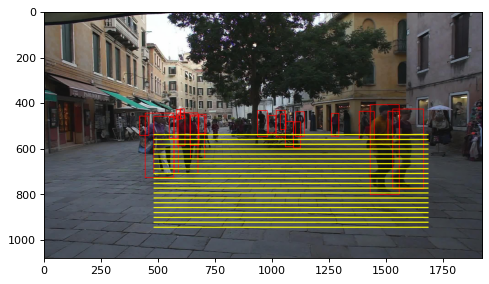

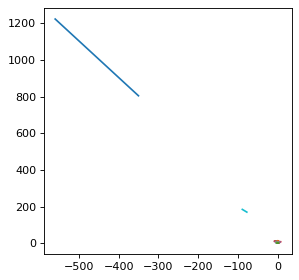

In [10]:
from camera_utils import AerialView
from geometry_3d import Rotation

root_dir = os.path.abspath('../')
dataset_name = 'mot'
# seq_name = 'MOT17-04-FRCNN'
# cam_info = {'w_img':1920,
#             'h_img':1080,
#             'alpha':68.32,
#             'beta' :0.13,
#             'fov'  :33.58}

seq_name = 'MOT17-02-FRCNN'
cam_info = {'w_img':1920,
            'h_img':1080,
            'alpha':84.35,
            'beta' :-1.08,
            'fov'  :100.8}

# seq_name = 'MOT17-13-FRCNN'
# cam_info = {'w_img':1920,
#             'h_img':1080,
#             'alpha':84.08,
#             'beta' :1.602,
#             'fov'  :86.22}

# seq_name = 'MOT17-09-FRCNN'
# cam_info = {'w_img':1920,
#             'h_img':1080,
#             'alpha':90.28,
#             'beta' :-2.21,
#             'fov'  :30.0}

# seq_name = 'MOT17-05-FRCNN'
# cam_info = {'w_img':640,
#             'h_img':480,
#             'alpha':81.22,
#             'beta' :0.99,
#             'fov'  :69.14}

# seq_name = 'MOT17-10-FRCNN'
# cam_info = {'w_img':1920,
#             'h_img':1080,
#             'alpha':76.8,
#             'beta' :1.59,
#             'fov'  :43.6}

# seq_name = 'MOT17-11-FRCNN'
# cam_info = {'w_img':1920,
#             'h_img':1080,
#             'alpha':72.20,
#             'beta' :-1.02,
#             'fov'  :47.85}

w_img, h_img = cam_info['w_img'], cam_info['h_img']
s      = gen_focal_length(cam_info['w_img'], cam_info['fov'])
camera = Camera(w_img = cam_info['w_img'],
                h_img = cam_info['h_img'],
                sx    = s, sy    = s, 
                cx = cam_info['w_img'] / 2, cy = cam_info['h_img'] / 2)

rotation = Rotation(np.array([cam_info['alpha'], cam_info['beta'], 0]), mode = 'ZYX')
# rotation = Rotation(np.array([cam_info['alpha'], cam_info['beta'], 0]), mode = 'XYZ')

surf_normal = gen_surf_normal(alpha = cam_info['alpha'],
                              beta  = cam_info['beta'])
cboard_mapping = CardBoard(camera, surf_normal)

track_file = os.path.join(root_dir, 'datasets', dataset_name, 'train', seq_name, 'gt/gt.txt')

fps = 30
boxloader    = BoxDataLoader(track_file = track_file,
                             img_size    = (w_img, h_img),
                             window      = int(fps * 2),
                             stride      = fps // 2,
                             height_dif_thresh  = 3,
                             front_ratio_thresh = 0.8,
                             fps         = fps)

img_dir = os.path.join(root_dir, 'datasets', dataset_name, 'train', seq_name, 'img1')
track_boxes  = boxloader.raw_tracks
print(track_boxes.shape)

frame_id     = 10
# load image
img = cv2.imread(img_dir + '/{:06d}.jpg'.format(frame_id))
img = cv2.cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

boxes = track_boxes[:, frame_id, :]
boxes = boxes[boxes[:, -1] > 0, :]

# num_boxes   = 10
num_boxes   = boxes.shape[0]
boxes = boxes[:num_boxes, :]
for i in range(boxes.shape[0]):
    draw_box(img, boxes[i,:], color = (255, 0, 0), thickness = 2)
rows, cols = 1, 1
fig = plt.figure(figsize=(16, 4), dpi=80)
ax  = fig.subplots(rows, cols)
# ax[1].imshow(draw_board)

# generate a set of lines
num_lines = 20
llx, rlx = w_img / 4, w_img * 7 / 8
llys     = np.linspace(h_img / 2, h_img * 7 / 8, num_lines)
ll_pts, rl_pts = np.array([[llx, ly] for ly in llys]), np.array([[rlx, ly] for ly in llys])
l_pts    = np.stack([ll_pts, rl_pts], axis = 0)
l_pts    = l_pts.transpose([1, 0, 2])
# project lines to ground floor
# line_pts = np.array([[w_img /4, h_img * 2/ 3], [3* w_img /4, h_img *2/ 3]])
# cv2.line(img, np.int16(line_pts[0]), np.int16(line_pts[1]), color = (255, 0, 0), thickness = 3)
# ax[0].imshow(img)
for i in range(l_pts.shape[0]):
    line_pts = l_pts[i]
    cv2.line(img, np.int16(line_pts[0]), np.int16(line_pts[1]), color = (255, 255, 0), thickness = 3)
ax.imshow(img)

# project a line to the ground floor
left_bot = boxes[:, :2].copy()
left_bot[:, 1] += boxes[:, 3]
right_bot       = left_bot.copy()
left_bot[:, 0] += boxes[:, 2]

img_gf_pts = np.concatenate([left_bot, right_bot], axis = 0)

aview = AerialView(camera, rotation)
# gf_pts     = cboard_mapping.map_img_pts_to_grf_pts(img_gf_pts)
gf_pts = aview.map_img_to_grf(img_gf_pts)
l_gf_pts = aview.map_img_to_grf(l_pts.reshape((-1, 2)))
l_gf_pts = l_gf_pts.reshape((-1, 2, 2))
print(l_gf_pts.shape)

left_pts   = gf_pts[:len(left_bot),  :]
right_pts  = gf_pts[len(right_bot):len(right_bot) * 2, :]

xmin, xmax = gf_pts[:, 0].min(), gf_pts[:, 0].max()
ymin, ymax = gf_pts[:, 1].min(), gf_pts[:, 1].max()
xmax_range = max(abs(xmin), abs(xmax))
ymax_range = max(abs(ymin), abs(ymax))

fig = plt.figure(figsize=(4, 4), dpi=80)
bx  = fig.subplots(1, 1)
for indx in range(left_pts.shape[0]):
    left_pt = left_pts[indx]
    right_pt = right_pts[indx]
    bx.plot([left_pt[0], right_pt[0]], [-left_pt[1], -right_pt[1]])
    # bx.plot([left_pt[0], right_pt[0]], [left_pt[1], right_pt[1]])
# bx.plot(gf_pts[-2:, 0],gf_pts[-2:, 1])
# bx.plot(gf_pts[-2:, 0],-gf_pts[-2:, 1])
# bx.set_xlim([-ymax_range / 2, ymax_range / 2])
# bx.set_ylim([0, ymax_range])
# print(gf_pts[-2:, :])
for i in range(l_gf_pts.shape[0]):
    gf_lines = l_gf_pts[i]
    bx.plot(gf_lines[:, 0],-gf_lines[:, 1])

In [11]:
def cut_quad3d(quad3d, base_u, base_v):
    quad3d = quad3d.reshape((-1, 4, 3))
    base_u = base_u.reshape((-1, 1, 3))
    base_v = base_v.reshape((-1, 1, 3))

    u = (quad3d * base_u).sum(axis = -1)  # N x 4
    v = (quad3d * base_v).sum(axis = -1)  # N x 4
    w = quad3d[:, :, 2]                   # N x 4

    new_z = w[:, :2].max(axis = 1, keepdims = True)

    left_mean = u[:, [0, 3]].mean(axis = 1, keepdims = True)  # N x 1
    right_mean = u[:,[1, 2]].mean(axis = 1, keepdims = True)  # N x 1

    inner_mask1 = np.logical_and(u <= right_mean, u >= left_mean)
    inner_mask2 = np.logical_and(u >= right_mean, u <= left_mean)
    inner_mask  = np.logical_or(inner_mask1, inner_mask2)

    u_min, u_max = u.min(), u.max()

    new_u_min = (u * inner_mask + (1. - inner_mask) * u_max).min(axis = 1, keepdims = True)
    new_u_max = (u * inner_mask + (1. - inner_mask) * u_min).max(axis = 1, keepdims = True)
    print(new_u_min.shape, new_u_max.shape)
    
    cboards = np.zeros(u.shape + (2,))
    cboards[:, :2, 1] = np.tile(new_z, (1, 2))
    cboards[:, 2:, 1] = 1.

    cboards[:, [0, 3], 0] = np.tile(new_u_min, (1, 2))
    cboards[:, [1, 2], 0] = np.tile(new_u_max, (1, 2))

    rect_cboards = np.zeros(quad3d.shape)
    rect_cboards[:, :, 2] = cboards[:, :, 1]
    print(base_u[:, 0, :])
    rect_cboards[:, :, 0] = cboards[:, :, 0] * base_u[:,0,0:1] + v * base_v[:, 0,0:1]
    rect_cboards[:, :, 1] = cboards[:, :, 0] * base_u[:,0,1:2] + v * base_v[:, 0,1:2]

    return rect_cboards

(23, 3)
[[9.99097313e-01 4.24801100e-02 4.41276899e-10]
 [9.98281488e-01 5.86009382e-02 6.01687112e-10]
 [9.98942089e-01 4.59859053e-02 4.76161947e-10]]
(23, 1) (23, 1)
[[9.99097313e-01 4.24801100e-02 4.41276899e-10]
 [9.98281488e-01 5.86009382e-02 6.01687112e-10]
 [9.98942089e-01 4.59859053e-02 4.76161947e-10]
 [9.93673603e-01 1.12306591e-01 1.13604897e-09]
 [9.94131660e-01 1.08176908e-01 1.09496155e-09]
 [9.85067027e-01 1.72171287e-01 1.73162773e-09]
 [9.86051001e-01 1.66443455e-01 1.67464610e-09]
 [9.85406114e-01 1.70219831e-01 1.71221445e-09]
 [9.85733942e-01 1.68311007e-01 1.69322523e-09]
 [9.98499709e-01 5.47570253e-02 5.63438750e-10]
 [9.96812779e-01 7.97764589e-02 8.12386402e-10]
 [9.89162355e-01 1.46825865e-01 1.47948116e-09]
 [9.88944471e-01 1.48286320e-01 1.49401049e-09]
 [9.98252796e-01 5.90876873e-02 6.06530339e-10]
 [9.88004820e-01 1.54423039e-01 1.55506233e-09]
 [9.83587314e-01 1.80432800e-01 1.81381431e-09]
 [9.93268026e-01 1.15838803e-01 1.17119210e-09]
 [9.78784108e-0

Text(0, 0.5, 'z')

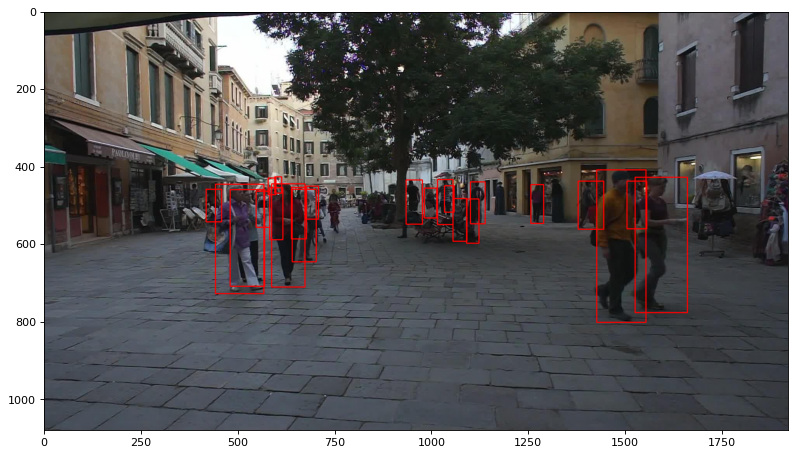

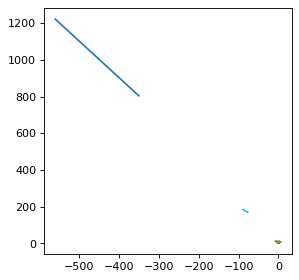

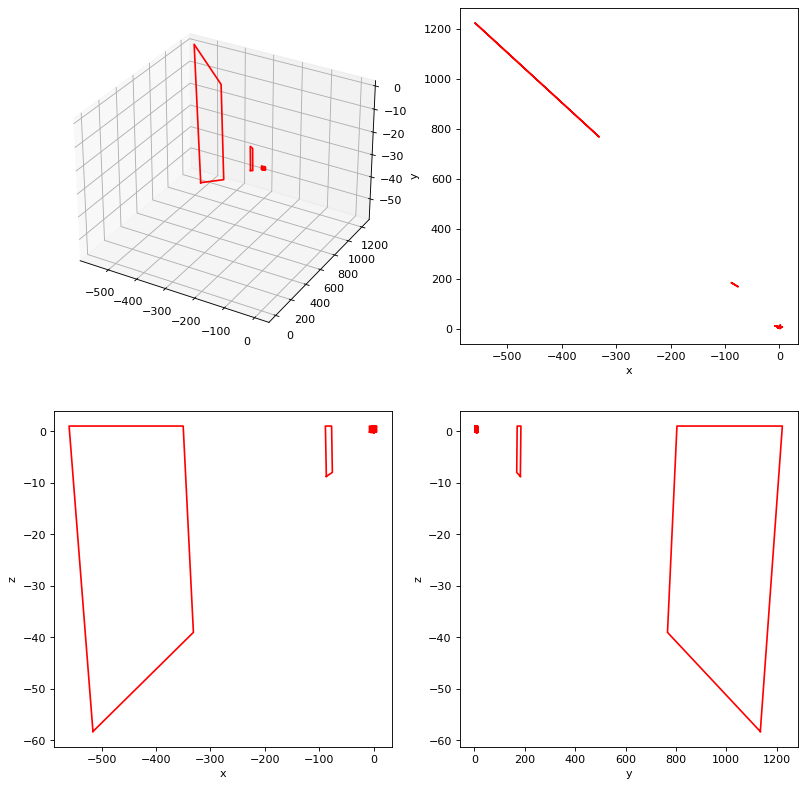

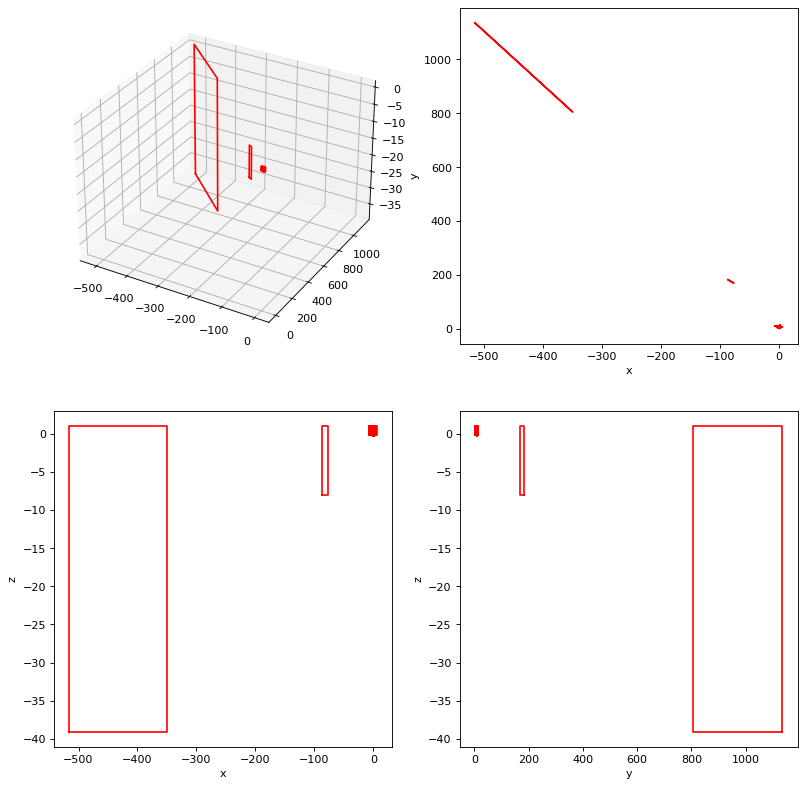

In [12]:
tls = boxes[:, :2].copy()

trs = tls.copy()
trs[:, 0] += boxes[:, 2]

brs = trs.copy()
brs[:, 1] += boxes[:, 3]

bls = tls.copy()
bls[:, 1] += boxes[:, 3]

corners  = np.stack([tls, trs, brs, bls], axis = 0)
corners  = corners.reshape((-1, 2))
rays     = camera.map_2d_pts_to_3d_rays(corners)
rot_rays = rotation.rotate(rays)

rot_rays = normalize_rays_3d(rot_rays, axis = 2)
rot_rays = rot_rays.T.reshape((4, -1, 3))

fig = plt.figure(figsize=(12, 8), dpi=80)
cx  = fig.add_subplot(111)
img = cv2.imread(img_dir + '/{:06d}.jpg'.format(frame_id))
img = cv2.cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()
for i in range(boxes.shape[0]):
    draw_box(img_copy, boxes[i,:], color = (255, 0, 0), thickness = 2)
cx.imshow(img_copy)

fig = plt.figure(figsize=(4, 4), dpi=80)
dx  = fig.add_subplot(111)
for i in range(rot_rays.shape[1]):
    dx.plot(rot_rays[2:, i, 0], -rot_rays[2:, i, 1])

line_vect  = rot_rays[2, :] - rot_rays[3, :]
line_vect  = line_vect / np.linalg.norm(line_vect, axis = 1, keepdims = True)
surf_n2    = np.cross(line_vect, np.array([0, 0, 1]))
surf_n2    = surf_n2 / np.linalg.norm(surf_n2, axis = 1, keepdims = True)

ds         = (rot_rays[2, :] * surf_n2).sum(axis = 1, keepdims = True)

rot_rays   = rot_rays.reshape((-1, 3))
scales     = np.tile(ds, (4, 1)) / (rot_rays * np.tile(surf_n2, (4, 1))).sum(axis = 1, keepdims = True)
quad3d     = rot_rays * scales
quad3d     = quad3d.reshape((4, -1, 3))
quad3d     = quad3d.transpose([1, 0, 2])

# plot cut 3d quadrangles
fig = plt.figure(figsize=(12, 12), dpi=80)
ex  = fig.add_subplot(221, projection = '3d')
draw_3d_quad = np.concatenate([quad3d, quad3d[:, 0:1, :]], axis = 1)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    ex.plot(quad[:, 0], -quad[:, 1], quad[:, 2], color = 'red')
ex  = fig.add_subplot(222)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    ex.plot(quad[:, 0], -quad[:, 1], color = 'red')
ex.set_xlabel('x')
ex.set_ylabel('y')
ex  = fig.add_subplot(223)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    ex.plot(quad[:, 0], quad[:, 2], color = 'red')
ex.set_xlabel('x')
ex.set_ylabel('z')
ex  = fig.add_subplot(224)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    ex.plot(-quad[:, 1], quad[:, 2], color = 'red')
ex.set_xlabel('y')
ex.set_ylabel('z')

# cut 3d quadrangels
x_positives = (line_vect[:, 0] > 0).reshape((-1, 1))
base_u  = line_vect * x_positives + line_vect * (x_positives - 1.)
base_v  = np.cross(base_u, np.array([0, 0, 1]))
print(base_u.shape)
print(base_u[:3, :])
cboards = cut_quad3d(quad3d, base_u, base_v)
print(cboards.shape)

# plot 3d quadrangles
quad3d = cboards.copy()
fig = plt.figure(figsize=(12, 12), dpi=80)
fx  = fig.add_subplot(221, projection = '3d')
draw_3d_quad = np.concatenate([quad3d, quad3d[:, 0:1, :]], axis = 1)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    fx.plot(quad[:, 0], -quad[:, 1], quad[:, 2], color = 'red')
fx  = fig.add_subplot(222)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    fx.plot(quad[:, 0], -quad[:, 1], color = 'red')
fx.set_xlabel('x')
fx.set_ylabel('y')
fx  = fig.add_subplot(223)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    fx.plot(quad[:, 0], quad[:, 2], color = 'red')
fx.set_xlabel('x')
fx.set_ylabel('z')
fx  = fig.add_subplot(224)
for i in range(draw_3d_quad.shape[0]):
    quad = draw_3d_quad[i, :]
    fx.plot(-quad[:, 1], quad[:, 2], color = 'red')
fx.set_xlabel('y')
fx.set_ylabel('z')

(23, 4, 3)


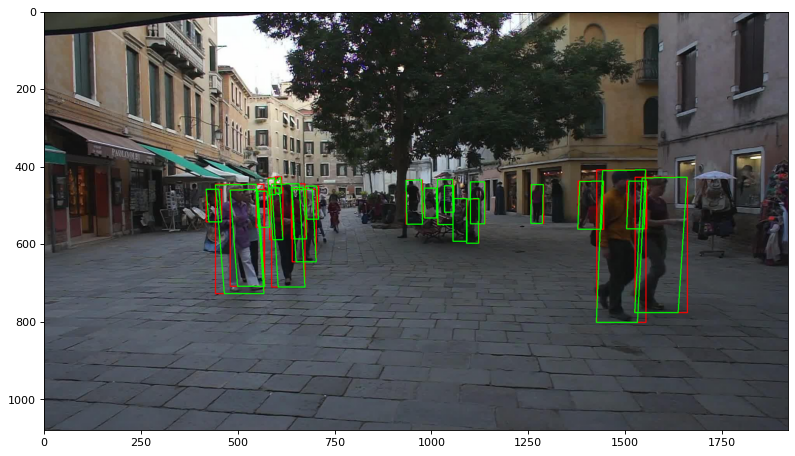

In [13]:
print(cboards.shape)
cb_rays = cboards.reshape((-1, 3)).T
cb_rays = rotation.rotate_inverse(cb_rays)
cb_img_pts = camera.map_3d_rays_to_2d_pts(cb_rays)
cb_img_pts = cb_img_pts.reshape((-1, 4, 2))

img_copy2 = img_copy.copy()
for i in range(cb_img_pts.shape[0]):
    cb_corners = cb_img_pts[i, :]
    draw_quad_box(img_copy2, cb_corners, color = (0, 255, 0), thickness = 2)

fig = plt.figure(figsize=(12, 8), dpi=80)
gx  = fig.add_subplot(111)
gx.imshow(img_copy2)

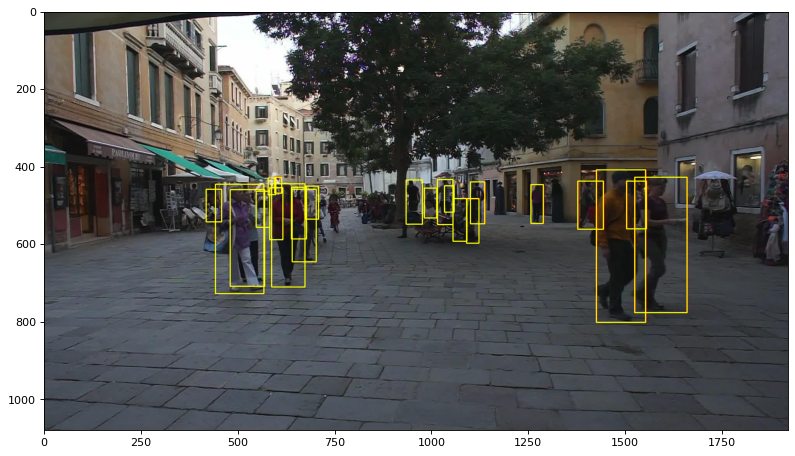

In [14]:
tlwhs = np.zeros(boxes.shape)

x_min, x_max = cb_img_pts[:, :, 0].min(axis = 1), cb_img_pts[:, :, 0].max(axis = 1)
y_min, y_max = cb_img_pts[:, :, 1].min(axis = 1), cb_img_pts[:, :, 1].max(axis = 1)
tlwhs[:, 0] = x_min
tlwhs[:, 1] = y_min
tlwhs[:, 2] = x_max - x_min
tlwhs[:, 3] = y_max - y_min

img_copy3 = img_copy.copy()
for i in range(tlwhs.shape[0]):
    tlwh = tlwhs[i, :]
    draw_box(img_copy3, tlwh, color = (255, 255, 0), thickness = 2)
fig = plt.figure(figsize=(12, 8), dpi=80)
gx  = fig.add_subplot(111)
gx.imshow(img_copy3)

In [15]:
# # project a line
# rows, cols = 1, 2
# fig = plt.figure(figsize=(16, 4), dpi=80)
# ax  = fig.subplots(rows, cols)
# pts = np.array([[w_img /4, h_img * 2/ 3], [3* w_img /4, h_img * 2 / 3]])
# cv2.line(img, np.int16(pts[0]), np.int16(pts[1]), color = (255, 0, 0), thickness = 3)
# ax[0].imshow(img)

# rays = cboard_mapping.camera.map_2d_pts_to_3d_rays(pts)
# print(rays.shape)
# print(surf_normal)
# surf_n = surf_normal.reshape((1, 3))
# pts3d = np.matmul(surf_n, rays) * rays
# pts3d = pts3d.T
# print(pts3d)
# base_x     = pts3d[0, :] - pts3d[1, :]
# base_x     = base_x / np.linalg.norm(base_x)
# base_y     = np.cross(surf_normal, base_x)
# print(base_y, np.linalg.norm(base_y))
# base_y     = base_y / np.linalg.norm(base_y)
# rot_matrix = np.stack([base_x, base_y, surf_normal], axis = 0).reshape((3, 3))

# # project pts onto the ground floor
# rays_rot  = np.matmul(rot_matrix, rays)
# pts3d_grf = normalize_rays_3d(rays_rot, axis = 2)
# ax[1].plot(pts3d_grf[0,:], pts3d_grf[, 1])
# # ax[1].scatter(pts3d_grf[0, :], pts3d_grf[1, :])
# # ax[1].set_ylim([0, 3])

# print(boxes.shape)
# cboard_mapping.set_rot_matrix(rot_matrix)
# # quad_3d  = cboard_mapping.bboxes_to_quadrangles3d(boxes)  # 3d quadrangles
# cquad_3d = cboard_mapping.bboxes2cboards_v2(boxes, aspect_ratio = 1./3)
# bquad_2d = cboard_mapping.cboards_to_quadrangles2d(cquad_3d)
# print(cquad_3d.shape, bquad_2d.shape)

# for i in range(bquad_2d.shape[0]):
#     bquad = bquad_2d[i, :]
#     draw_quad_box(img, bquad, color = (0, 255, 0), thickness = 2)

# ax[0].imshow(img)

In [16]:
# # project a line to the ground floor
# left_bot = boxes[:, :2].copy()
# left_bot[:, 1] += boxes[:, 3]
# right_bot       = left_bot.copy()
# left_bot[:, 0] += boxes[:, 2]

# img_gf_pts = np.concatenate([left_bot, right_bot, pts], axis = 0)
# print(img_gf_pts.shape)

# gf_pts     = cboard_mapping.map_img_pts_to_grf_pts(img_gf_pts)
# print(gf_pts.shape)

# left_pts   = gf_pts[:len(left_bot),  :]
# right_pts  = gf_pts[len(right_bot):len(right_bot) * 2, :]

# xmin, xmax = gf_pts[:, 0].min(), gf_pts[:, 0].max()
# ymin, ymax = gf_pts[:, 1].min(), gf_pts[:, 1].max()
# xmax_range = max(abs(xmin), abs(xmax))
# ymax_range = max(abs(ymin), abs(ymax))

# fig = plt.figure(figsize=(4, 4), dpi=80)
# bx  = fig.subplots(1, 1)
# for indx in range(left_pts.shape[0]):
#     left_pt = left_pts[indx]
#     right_pt = right_pts[indx]
#     bx.plot([left_pt[0], right_pt[0]], [left_pt[1], right_pt[1]])
# bx.plot(gf_pts[-2:, 0],gf_pts[-2:, 1])
# bx.set_xlim([-ymax_range / 2, ymax_range / 2])
# bx.set_ylim([0, ymax_range])